# Week2: データ収集 & 前処理 (Oxford-IIIT Pet, Cats only)

このノートは **Portfolio/catbreed-portfolio/backend/notebooks/** に置く前提です。

データは **Portfolio/catbreed-portfolio/backend/data/oxford-iiit-pet/** 配下に保存します：

```
backend/
  data/
    oxford-iiit-pet/
      raw/                # images.tar.gz / annotations.tar.gz を配置＆展開
      processed_cats/     # このノートで作成（train/val/test）
  notebooks/
    Week2_01_dataset_preparation.ipynb  # ← このファイル
```

※ ネットワーク環境に依存するため、このノートではダウンロードは行いません。
公式からアーカイブを取得して `raw/` に置いたうえで解凍してください：
- images: `images.tar.gz`
- annotations: `annotations.tar.gz`
公式: <http://www.robots.ox.ac.uk/~vgg/data/pets/>


## 0. セットアップ
- ライブラリのインポート
- 乱数シード固定
- パス定義（このノートが `backend/notebooks` にある前提で相対パスを解決）


In [1]:
import os, random, shutil, tarfile
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# このノートが backend/notebooks にある前提
NB_DIR = Path.cwd()
BACKEND_DIR = NB_DIR.parent
DATA_ROOT = BACKEND_DIR / 'data' / 'oxford-iiit-pet'
RAW_DIR = DATA_ROOT / 'raw'
PROCESSED_DIR = DATA_ROOT / 'processed_cats'

RAW_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
BACKEND_DIR, DATA_ROOT

(WindowsPath('c:/Users/81802/Portfolio/catbreed-portfolio/backend'),
 WindowsPath('c:/Users/81802/Portfolio/catbreed-portfolio/backend/data/oxford-iiit-pet'))

## 1. 解凍チェック（必要に応じて展開）
- `raw/images.tar.gz` と `raw/annotations.tar.gz` があれば展開
- 既に展開済みならスキップ


In [2]:
def maybe_extract(tgz_path: Path, dest: Path):
    if not tgz_path.exists():
        print(f"Skip: {tgz_path.name} が見つかりません。手動で配置してください。")
        return
    # ルートに images/ または annotations/ があればスキップ
    marker = 'images' if 'images' in tgz_path.name else 'annotations'
    if (dest / marker).exists():
        print(f"Skip: {marker}/ は既に存在します。")
        return
    with tarfile.open(tgz_path, 'r:gz') as tar:
        tar.extractall(path=dest)
        print(f"Extracted: {tgz_path.name}")

maybe_extract(RAW_DIR / 'images.tar.gz', RAW_DIR)
maybe_extract(RAW_DIR / 'annotations.tar.gz', RAW_DIR)

C:\Users\81802\AppData\Local\Temp\ipykernel_9096\2863535740.py:11: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=dest)


Extracted: images.tar.gz
Extracted: annotations.tar.gz


## 2. クラス情報の読込（猫種のみ）
- `annotations/list.txt` を読み込み、species==1 を猫とみなす
- そこからクラス名を抽出


In [3]:
LIST_TXT = RAW_DIR / 'annotations' / 'list.txt'
assert LIST_TXT.exists(), f"{LIST_TXT} が見つかりません。アーカイブの展開を確認してください。"

records = []
with open(LIST_TXT, 'r') as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith('#'):
            continue
        parts = line.split()
        if len(parts) == 4:
            img_name, class_id, species, breed_id = parts
            records.append({
                'img_name': img_name,
                'class_id': int(class_id),
                'species': int(species),
                'breed_id': int(breed_id),
            })
import pandas as pd
df = pd.DataFrame(records)
df_cats = df[df['species'] == 1].copy()
def extract_class_name(img_name: str) -> str:
    return img_name.split('_')[0]
df_cats['class_name'] = df_cats['img_name'].apply(extract_class_name)
classes = sorted(df_cats['class_name'].unique())
classes, len(classes)

(['Abyssinian',
  'Bengal',
  'Birman',
  'Bombay',
  'British',
  'Egyptian',
  'Maine',
  'Persian',
  'Ragdoll',
  'Russian',
  'Siamese',
  'Sphynx'],
 12)

## 3. （任意）クラス数を絞る（例: 20種）
- `selected_classes` を設定すれば、以降はそのクラスのみを使用


In [4]:
# 例: 先頭20種だけ使う（順序はアルファベット順の classes に依存）
USE_N_CLASSES = 20  # 20種に絞る
selected_classes = classes[:USE_N_CLASSES]
df_cats = df_cats[df_cats['class_name'].isin(selected_classes)].copy()
classes = selected_classes
classes, len(classes)

(['Abyssinian',
  'Bengal',
  'Birman',
  'Bombay',
  'British',
  'Egyptian',
  'Maine',
  'Persian',
  'Ragdoll',
  'Russian',
  'Siamese',
  'Sphynx'],
 12)

## 4. train/val/test 分割（8:1:1）とファイル配置
- 出力: `backend/data/oxford-iiit-pet/processed_cats/{train,val,test}/{class_name}/image.jpg`

In [5]:
from sklearn.model_selection import train_test_split

# 既存の processed をクリーン
if PROCESSED_DIR.exists():
    shutil.rmtree(PROCESSED_DIR)
for split in ['train', 'val', 'test']:
    for c in classes:
        (PROCESSED_DIR / split / c).mkdir(parents=True, exist_ok=True)

# Stratified split
train_df, tmp_df = train_test_split(
    df_cats, test_size=0.2, random_state=42, stratify=df_cats['class_name']
)
val_df, test_df = train_test_split(
    tmp_df, test_size=0.5, random_state=42, stratify=tmp_df['class_name']
)
print('train:', train_df.shape, 'val:', val_df.shape, 'test:', test_df.shape)

IMG_DIR = RAW_DIR / 'images'
def copy_split(split_df, split_name):
    for _, row in split_df.iterrows():
        src_jpg = IMG_DIR / f"{row['img_name']}.jpg"
        src_png = IMG_DIR / f"{row['img_name']}.png"
        dst = PROCESSED_DIR / split_name / row['class_name'] / f"{row['img_name']}"
        if src_jpg.exists():
            shutil.copy2(src_jpg, dst.with_suffix('.jpg'))
        elif src_png.exists():
            shutil.copy2(src_png, dst.with_suffix('.png'))
        else:
            print('Missing image:', row['img_name'])

copy_split(train_df, 'train')
copy_split(val_df, 'val')
copy_split(test_df, 'test')
print('Done copying to processed_cats/.')

train: (1896, 5) val: (237, 5) test: (238, 5)
Done copying to processed_cats/.


## 5. EDA: 分布とサンプル可視化


,train,val,test
class_name,,,
Abyssinian,158,20,20
Bengal,160,20,20
Birman,160,20,20
Bombay,147,18,19
British,160,20,20
Egyptian,152,19,19
Maine,160,20,20
Persian,160,20,20
Ragdoll,160,20,20


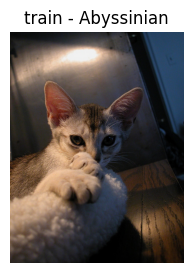

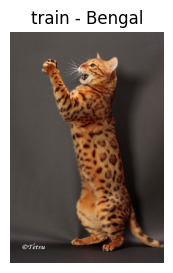

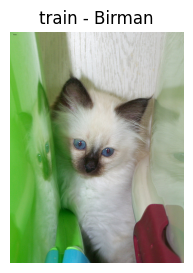

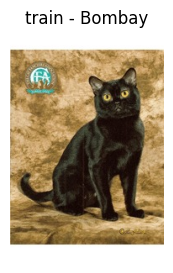

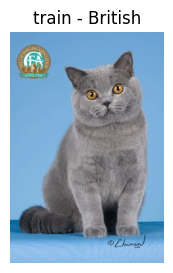

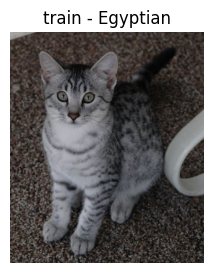

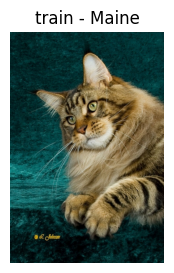

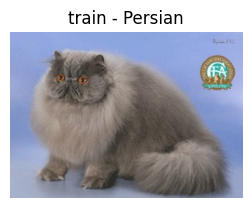

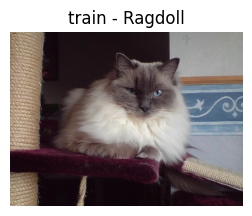

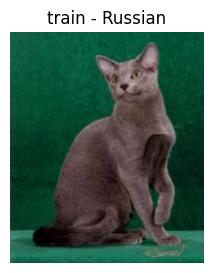

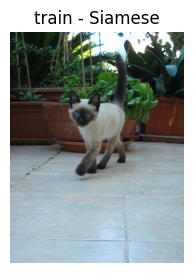

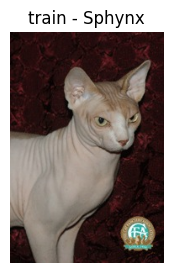

Displayed 12 images.


In [6]:
import pandas as pd
def count_per_class(df):
    return df['class_name'].value_counts().sort_index()

display(pd.DataFrame({
    'train': count_per_class(train_df),
    'val': count_per_class(val_df),
    'test': count_per_class(test_df)
}).fillna(0).astype(int))

def show_samples(split='train', num_per_class=1, img_size=(3,3)):
    base = PROCESSED_DIR / split
    shown = 0
    for c in classes:
        images = list((base / c).glob('*'))[:num_per_class]
        for p in images:
            img = plt.imread(p)
            plt.figure(figsize=(img_size[0], img_size[1]))
            plt.imshow(img)
            plt.title(f"{split} - {c}")
            plt.axis('off')
            plt.show()
            shown += 1
    print(f"Displayed {shown} images.")

show_samples('train', num_per_class=1)

## 6. DataLoader と EfficientNet-B0 雛形


In [7]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
val_tfms = transforms.Compose([
    transforms.Resize(IMG_SIZE + 32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_ds = datasets.ImageFolder(PROCESSED_DIR / 'train', transform=train_tfms)
val_ds = datasets.ImageFolder(PROCESSED_DIR / 'val', transform=val_tfms)
test_ds = datasets.ImageFolder(PROCESSED_DIR / 'test', transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

num_classes = len(train_ds.classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
in_features = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(in_features, num_classes)
model = model.to(device)

device, num_classes, sum(p.numel() for p in model.parameters())

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\81802/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100.0%


(device(type='cpu'), 12, 4022920)

## 7. 次のステップ
- （任意）クラス不均衡に対する重み計算
- 学習ループの実装（Week3想定）
- 早期終了 & ベストモデル保存
- テスト評価 & 混同行列
